In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)


## Carrying out A/B Testing

In [2]:
 #COMPARING TWO GROUPS
    #Treatment group and control group

In [3]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [4]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


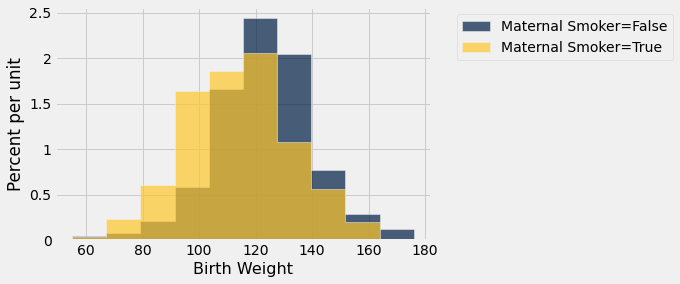

In [5]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [6]:
#NULL
    #In the population, distribution of the birth 
    #weights of the babies in the two groups are the 
    #same
#ALTERNATIVE
    #In the population, the babies of the mothers who smoked were lighter,
    #on average, than the babies of the non-smokers

In [7]:
#Take Mean_weight(B) - Mean_weight(A)

In [8]:
#if 0:
    #Null hypothesis is true.
        #weights of the babies in the two groups are the 
        #same
#else if (very -ve)
        #Alternative
        #(very -ve values) favour the alternative

## Test Statistic

### [QUESTION] What values of the statistic are in favour of the alternative: positive or negative?

In [9]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [10]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [11]:
def difference_of_means(table, group_label):
    """Takes: name of table, 
    column label that indicates whoch group the row relates to
    Returns: Difference of mean birth weights of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select('Birth Weight', group_label)
    
    #table with group means
    means_table = reduced.group(group_label, np.average)
    
    #array with group means
    means = means_table.column('Birth Weight average')
    
    #print("Mean of B = ", means.item(1), " | Mean of A = ", means.item(0))
    return means.item(1) - means.item(0)

In [12]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

## Random Permutation(Shuffling)

In [13]:
staff = Table().with_columns(
    'Names', make_array('Jim', 'Pam', 'Dwight', 'Michael'),
    'Ages', make_array(29,28,34,41))

In [14]:
staff

Names,Ages
Jim,29
Pam,28
Dwight,34
Michael,41


In [15]:
staff.sample()

Names,Ages
Pam,28
Dwight,34
Jim,29
Dwight,34


In [16]:
staff.sample(with_replacement = False)

Names,Ages
Michael,41
Pam,28
Jim,29
Dwight,34


In [17]:
#Ages in the same order but rearrange the names

In [18]:
shuffled_names = staff.sample(with_replacement = False).column('Names')
staff.with_column('Shuffled', shuffled_names)

Names,Ages,Shuffled
Jim,29,Michael
Pam,28,Dwight
Dwight,34,Jim
Michael,41,Pam


## Simulation Under Null Hypothesis

In [19]:
#Whole table was shuffled and then the name column was chosen.
#In the table, one column cannot be shuffled.
#Make another table, shuffle all, then only take the names column and add it to
# the ages in the first table

In [20]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [21]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column('Maternal Smoker')
shuffled_labels

array([False, False, False, ..., False, False, False])

In [22]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels)

In [23]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,False
True,128,False
True,108,True
False,136,True
False,138,True
False,132,False
False,120,False
True,143,False
False,140,True


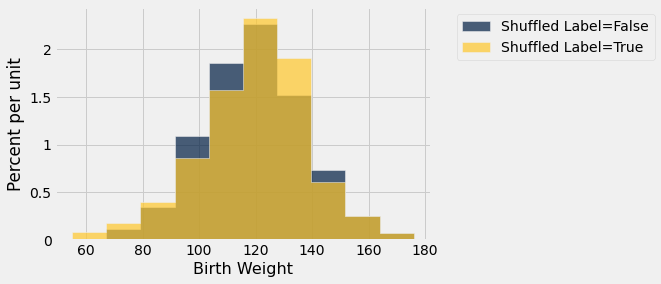

In [24]:
original_and_shuffled.hist('Birth Weight', group='Shuffled Label')

In [25]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

0.045440833676124726

In [26]:
#We created a synthetic dataset.
#Under the null hypothesis, such a dataset (where shuffling is performed) is valid


## Permutation Test

In [34]:
def one_simulated_difference_of_means():
    """Returns: Difference of mean birthweights
    of babies of smokers vs non-smokers after shuffling labels"""
    
    #array of shuffled labels
    shuffled_labels = births.sample(with_replacement = False).column(
        'Maternal Smoker')    
                                                                     
    #table of numerical variable and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')
    

In [35]:
one_simulated_difference_of_means()

1.390487072840017

In [33]:
differences = make_array()
    
for i in np.arange(2500):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

Observed Difference -9.266142572024918


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

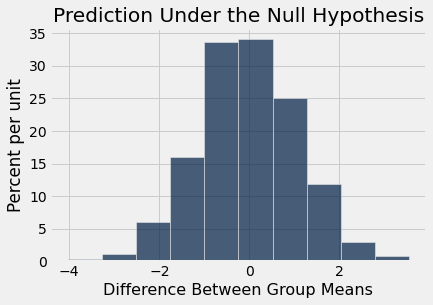

In [36]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference', observed_difference)
plt.title('Prediction Under the Null Hypothesis')

## Randomized Controlled Experiment

In [37]:
rct = Table.read_table('bta.csv')
rct.show()

#1 got better
#0 did not get better

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [42]:
rct.pivot('Result', 'Group')
#rct.pivot(column_label, row_label)

Group,0,1
Control,14,2
Treatment,6,9


In [41]:
rct.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6
